# **Bone Fracture Multi-Region X-ray Images Classification**

## Import Libraries

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import os, shutil, json, zipfile, random, math
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras import callbacks
import glob

2024-05-06 11:09:21.076673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 11:09:21.076843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 11:09:21.328861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Set Matplotlib defaults
sns.set_style('darkgrid')
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=25,
    titlepad=10,
)

## Loading the data

In [6]:
print(os.listdir("../input"))

['fracture-multi-region-x-ray-data']


In [52]:
main_path = os.listdir('/kaggle/input/fracture-multi-region-x-ray-data')
print(main_path)

['README.dataset.txt', 'Bone_Fracture_Binary_Classification']


In [54]:
dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/'

In [9]:
subdirectories = os.listdir(dir)

# Print the names of the subdirectories
for subdirectory in subdirectories:
    print(subdirectory)

val
test
train


In [ ]:
train_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'
val_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val'
test_dir = '../input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test'


In [ ]:
class_names=os.listdir(train_dir)
for subfolder in class_names :
    print(subfolder)

not fractured
fractured


## Exploratory Data Analysis

In [113]:
train_not_fractured = glob.glob(train_dir+"/not fractured/*.png")
train_fractured = glob.glob(train_dir+"/fractured/*.png")

val_not_fractured = glob.glob(val_dir+"/not fractured/*png")
val_fractured = glob.glob(val_dir+"/fractured/*.png")

test_not_fractured = glob.glob(test_dir+"/not fractured/*.png")
test_fractured = glob.glob(test_dir+"/fractured/*png")

In [114]:
train_list = [x for x in train_not_fractured]
train_list.extend([x for x in train_fractured])

train_df = pd.DataFrame(np.concatenate([["Not Fractured"]*len(train_not_fractured) , ["Fractured"]*len(train_fractured)]), columns = ['class'])
train_df['image'] = [x for x in train_list]
##########################################################
val_list = [x for x in val_not_fractured]
val_list.extend([x for x in val_fractured])

val_df = pd.DataFrame(np.concatenate([["Not Fractured"]*len(val_not_fractured) , ["Fractured"]*len(val_fractured)]), columns = ['class'])
val_df['image'] = [x for x in val_list]

#########################################################

test_list = [x for x in test_not_fractured]
test_list.extend([x for x in test_fractured])

test_df = pd.DataFrame(np.concatenate([["Not Fractured"]*len(test_not_fractured) , ["Fractured"]*len(test_fractured)]), columns = ['class'])
test_df['image'] = [x for x in test_list]

In [119]:
train_df.head()

,class,image
0,Not Fractured,/kaggle/working/train/not fractured/0047.png
1,Not Fractured,/kaggle/working/train/not fractured/13.png
2,Not Fractured,/kaggle/working/train/not fractured/14.png
3,Not Fractured,/kaggle/working/train/not fractured/23.png
4,Not Fractured,/kaggle/working/train/not fractured/2.png


In [118]:
val_df.head()

,class,image
0,Not Fractured,../input/fracture-multi-region-x-ray-data/Bone...
1,Not Fractured,../input/fracture-multi-region-x-ray-data/Bone...
2,Not Fractured,../input/fracture-multi-region-x-ray-data/Bone...
3,Not Fractured,../input/fracture-multi-region-x-ray-data/Bone...
4,Not Fractured,../input/fracture-multi-region-x-ray-data/Bone...


In [120]:
test_df.tail()

,class,image
52,Fractured,../input/fracture-multi-region-x-ray-data/Bone...
53,Fractured,../input/fracture-multi-region-x-ray-data/Bone...
54,Fractured,../input/fracture-multi-region-x-ray-data/Bone...
55,Fractured,../input/fracture-multi-region-x-ray-data/Bone...
56,Fractured,../input/fracture-multi-region-x-ray-data/Bone...


In [121]:
# Get the counts for each class
train_cases_count = train_df['class'].value_counts()
print(train_cases_count)

class
Fractured        48
Not Fractured    27
Name: count, dtype: int64


In [122]:
val_cases_count = val_df['class'].value_counts()
print(val_cases_count)

class
Fractured        41
Not Fractured    18
Name: count, dtype: int64


In [123]:
test_cases_count = test_df['class'].value_counts()
print(test_cases_count)

class
Fractured        39
Not Fractured    18
Name: count, dtype: int64


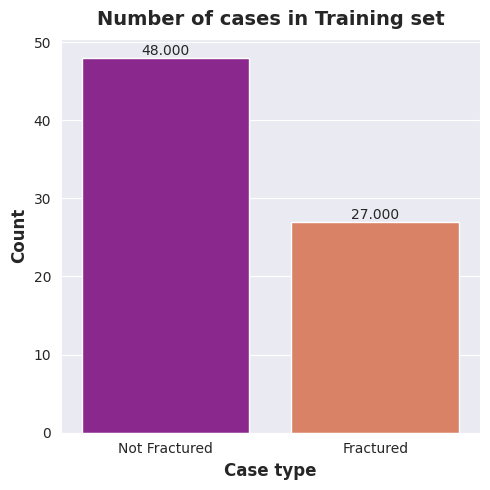

In [124]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=train_cases_count.index, y= train_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_cases_count.index)), ['Not Fractured', 'Fractured'])
plt.show()

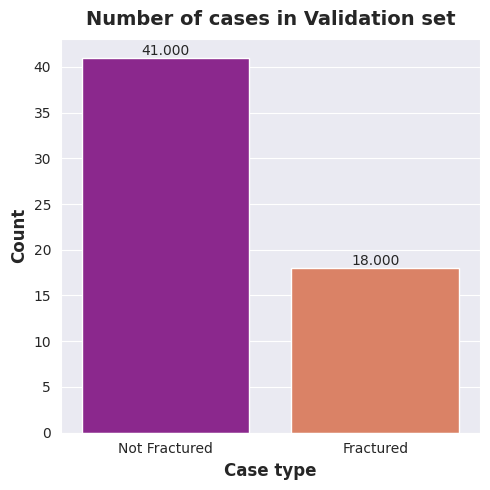

In [125]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=val_cases_count.index, y= val_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Validation set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(val_cases_count.index)), ['Not Fractured', 'Fractured'])
plt.show()

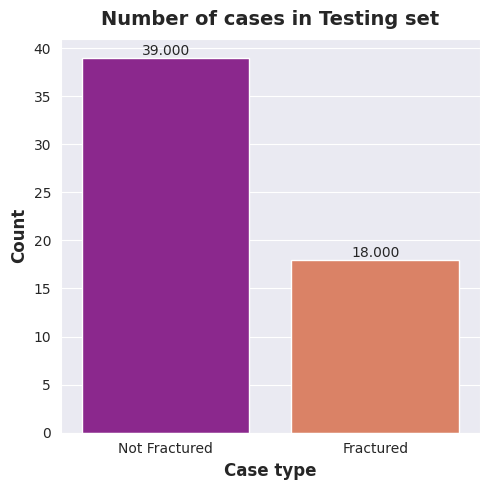

In [126]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values, palette = "plasma")
ax.bar_label(ax.containers[0], fmt='%.3f')
plt.title('Number of cases in Testing set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_cases_count.index)), ['Not Fractured', 'Fractured'])
plt.show()

libpng warning: iCCP: known incorrect sRGB profile


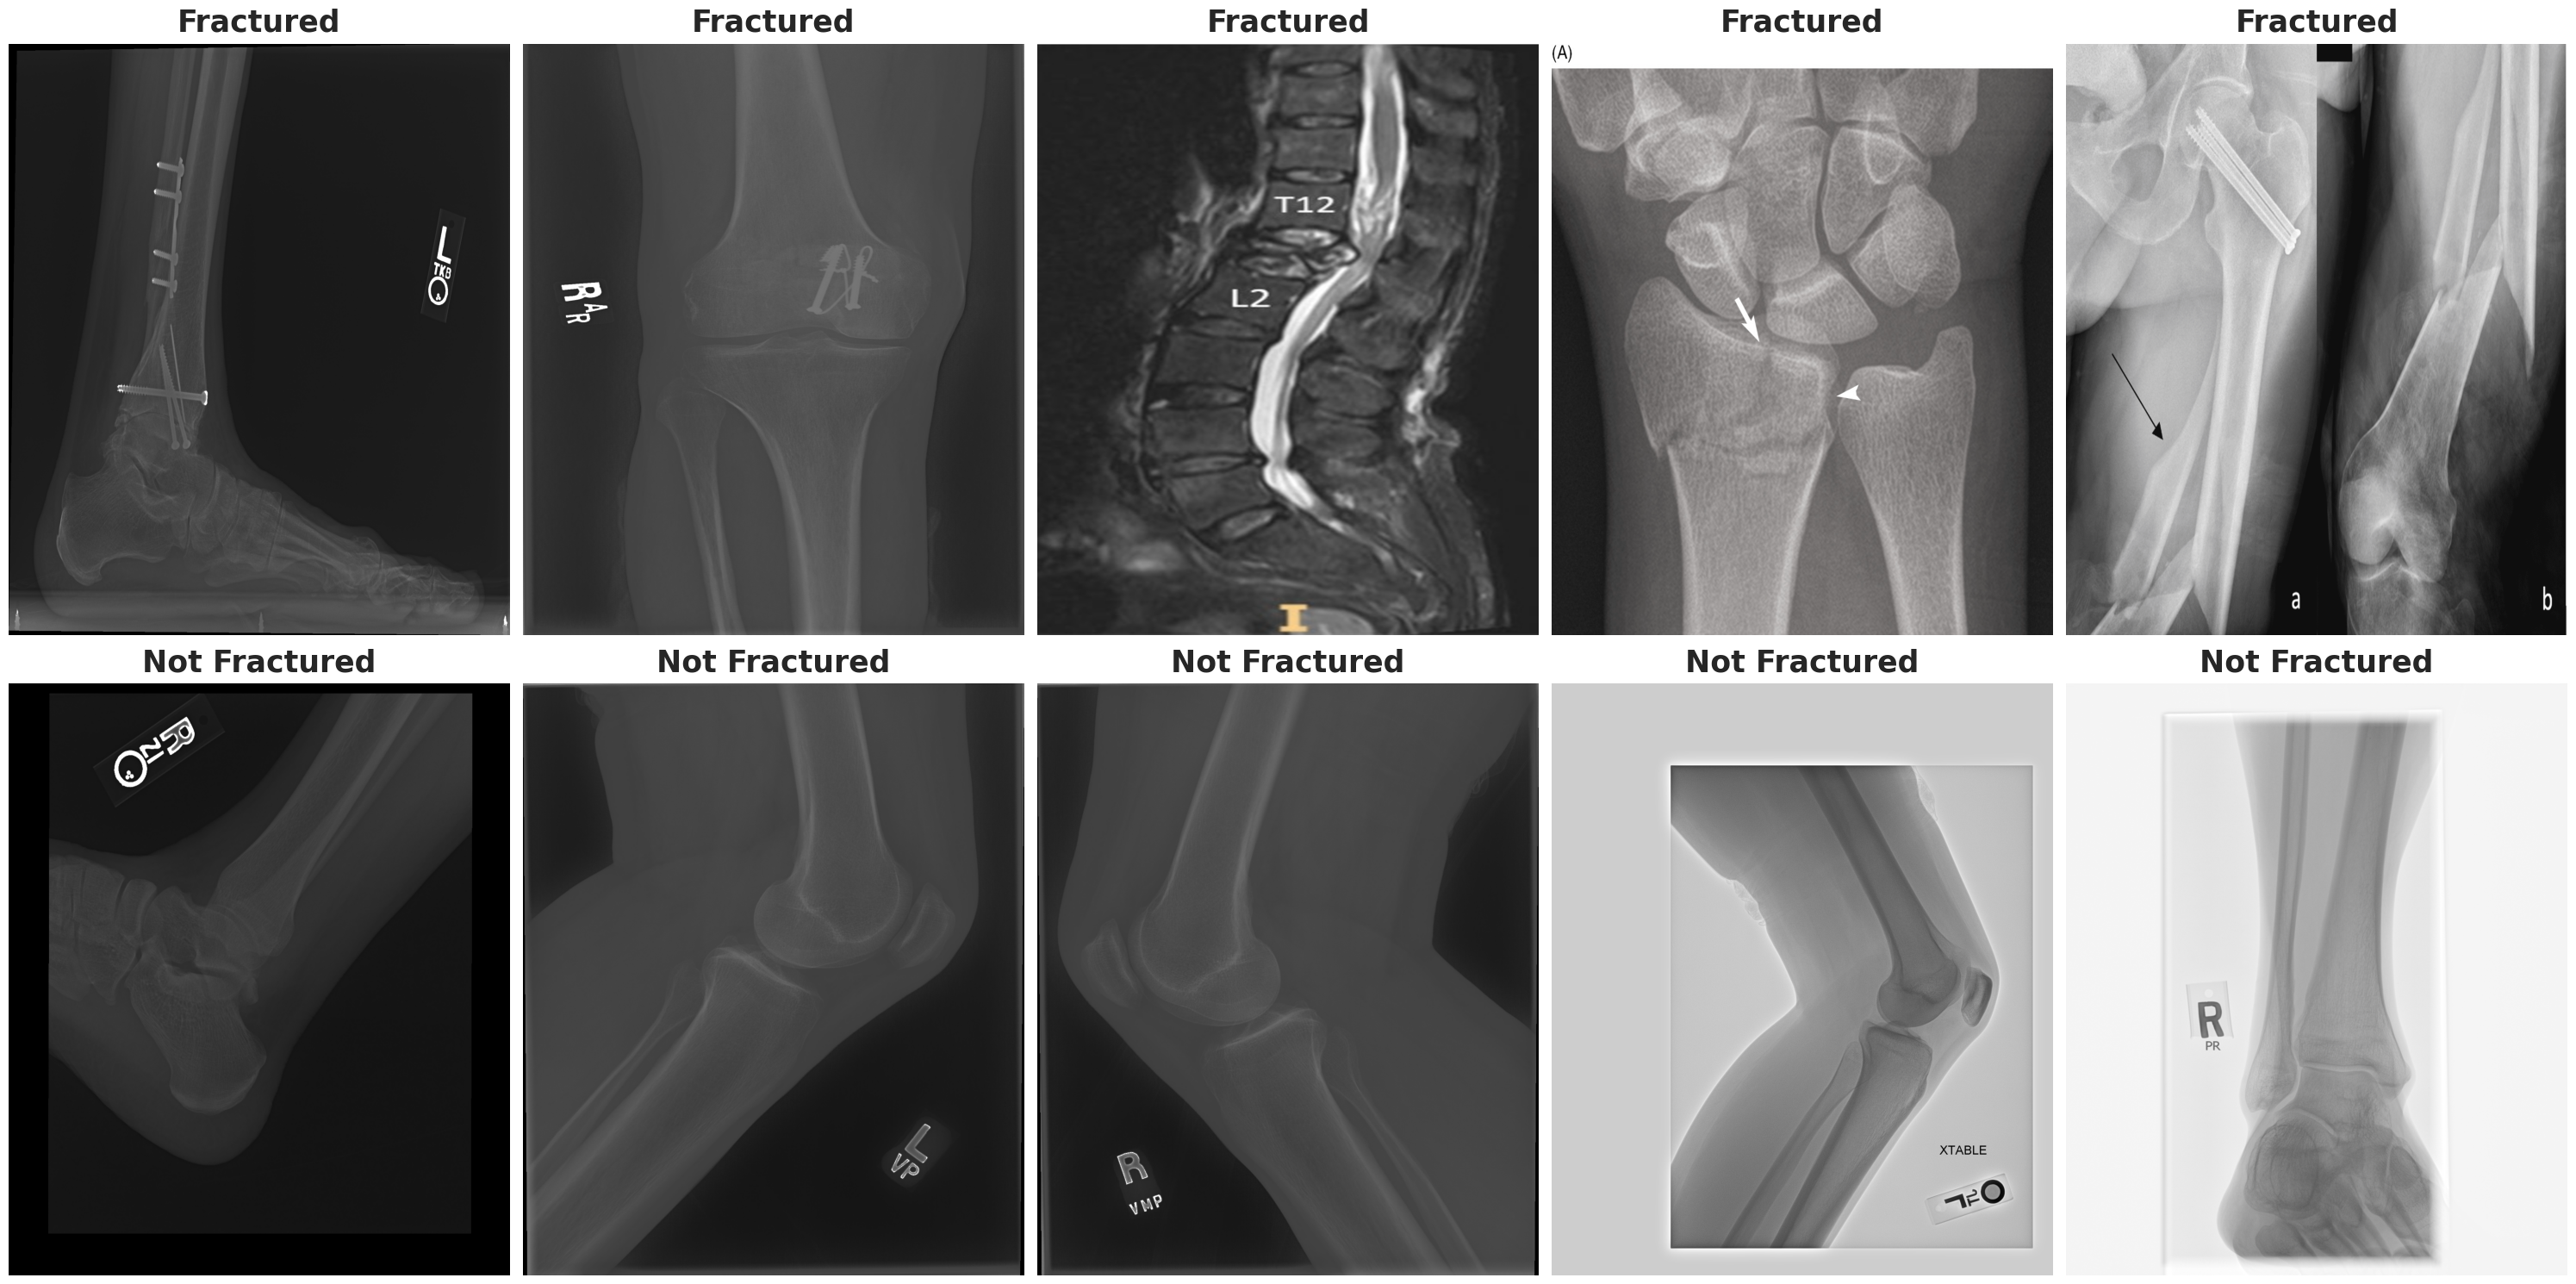

In [127]:
# Get few samples for both the classes
fractured_samples = (train_df[train_df['class']=="Fractured"]['image'].iloc[:5]).tolist()
not_fractured_samples = (train_df[train_df['class']=="Not Fractured"]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = fractured_samples + not_fractured_samples
del fractured_samples, not_fractured_samples
#plt.rcParams['font.size'] = 15
# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,15))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Fractured")
    else:
        ax[i//5, i%5].set_title("Not Fractured")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

## Data Preprocessing

In [ ]:

train_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured'
train_not_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured'


test_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured'
test_not_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured'

val_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured'
val_not_fractured = '/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured'

### Data Cleaning - Identifying and Removing Corrupted Images

In [ ]:
def check_image_readability(folder_path):
    file_list = os.listdir(folder_path)
    
    errored_images = []
    correct_images = []

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        try:
            with Image.open(file_path) as img:
                img.load()
            correct_images.append(file_path)
        except Exception as e:
            print(e)
            print(file_path)
            errored_images.append(file_path)
            continue
    
    if errored_images:
        print("There are errored images")
    else:
        print("All images are readable.")
    return errored_images, correct_images

#### Checking for Images Readability in Each Class of the Training Set

In [ ]:
errored_images_1, correct_images_1 = check_image_readability(train_fractured)
print(len(errored_images_1), len(correct_images_1))

All images are readable.
0 4606


In [ ]:
errored_images_2, correct_images_2 = check_image_readability(train_not_fractured)
print(len(errored_images_2), len(correct_images_2))

image file is truncated (40 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
image file is truncated (14 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
image file is truncated (1 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg
image file is truncated (33 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg
image file is truncated (10 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/I

#### Checking for Images Readability in Each Class of the Validation Set

In [ ]:
corrupt_images_1, valid_images_1 = check_image_readability(val_fractured)
print(len(corrupt_images_1), len(valid_images_1))

All images are readable.
0 337


In [ ]:
corrupt_images_2, valid_images_2 = check_image_readability(val_not_fractured)
print(len(corrupt_images_2), len(valid_images_2))

image file is truncated (40 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg
image file is truncated (14 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg
image file is truncated (1 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg
image file is truncated (33 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg
image file is truncated (10 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.

#### Checking for Images Readability in Each Class of the Test Set

In [ ]:
corr_images_1, val_images_1 = check_image_readability(test_fractured)
print(len(corr_images_1), len(val_images_1))

All images are readable.
0 238


In [ ]:
corr_images_2, val_images_2 = check_image_readability(test_not_fractured)
print(len(corr_images_2), len(val_images_2))

image file is truncated (40 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004347.jpg
image file is truncated (14 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg
image file is truncated (1 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg
image file is truncated (33 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004149.jpg
image file is truncated (10 bytes not processed)
/kaggle/input/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG000

#### Create New Directory for Each Set to Contain the Readable Images

In [ ]:
def create_directory(directories):
    for directory in directories:
        if not os.path.exists(directory):
            os.mkdir(directory)
            print('Created {}'.format(directory))
        else:
            print('{} exists'.format(directory))

In [ ]:
def move_images(images_list, to_dir):
    if not os.path.exists(to_dir):
        os.mkdir(to_dir)
    
    for image_path in images_list:
        image_name = os.path.basename(image_path)
        destination_path = os.path.join(to_dir, image_name)
        shutil.copy(image_path, destination_path)
    
    print("Images moved successfully to", to_dir)

In [ ]:
train_direct = '/kaggle/working/train'
valid_direct = '/kaggle/working/val'
test_direct = '/kaggle/working/test'

create_directory([train_direct,valid_direct,test_direct])

#### Moving images to the new directories

In [ ]:
move_images(correct_images_1, train_direct + '/' +os.path.basename(train_fractured))
move_images(correct_images_2, train_direct + '/' +os.path.basename(train_not_fractured))

Images moved successfully to /kaggle/working/train/fractured
Images moved successfully to /kaggle/working/train/not fractured


In [ ]:
move_images(valid_images_1, valid_direct + '/' +os.path.basename(val_fractured))
move_images(valid_images_2, valid_direct + '/' +os.path.basename(val_not_fractured))

Images moved successfully to /kaggle/working/val/fractured
Images moved successfully to /kaggle/working/val/not fractured


In [ ]:
move_images(val_images_1, test_direct + '/' +os.path.basename(test_fractured))
move_images(val_images_2, test_direct + '/' +os.path.basename(test_not_fractured))

Images moved successfully to /kaggle/working/test/fractured
Images moved successfully to /kaggle/working/test/not fractured


In [ ]:
root_train_dir = '/kaggle/working/train'
train_fractured = '/kaggle/working/train/fractured'
train_not_fractured = '/kaggle/working/train/not fractured'

In [ ]:
root_val_dir = '/kaggle/working/val'
val_fractured  = '/kaggle/working/val/fractured'
val_not_fractured  = '/kaggle/working/val/not fractured'

In [ ]:
root_test_dir = '/kaggle/working/test'
test_fractured = '/kaggle/working/test/fractured'
test_not_fractured = '/kaggle/working/test/not fractured'

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(root_train_dir)

Found 9240 files belonging to 2 classes.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(root_val_dir)

Found 823 files belonging to 2 classes.


In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(root_test_dir)

Found 500 files belonging to 2 classes.


In [ ]:
print(type(train_data),'\n')
print(len(train_data),'\n')
print(train_data.element_spec)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'> 

289 

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print(type(val_data),'\n')
print(len(val_data),'\n')
print(val_data.element_spec)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'> 

26 

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [ ]:
print(type(test_data),'\n')
print(len(test_data),'\n')
print(test_data.element_spec)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'> 

16 

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


#### Normalize the Images

In [ ]:
scaled_train_data = train_data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_val_data = val_data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_test_data = test_data.map(lambda x,y: (x/255, y))

## Modelling

In [93]:
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

x = Conv2D(16, (3, 3), 1, activation='relu')(inputs)
x = MaxPooling2D()(x)
x = Conv2D(32, (3, 3), 1, activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3, 3), 1, activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [94]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

In [96]:
history = model.fit(scaled_train_data,epochs = 10,
          validation_data = scaled_val_data,
          callbacks=[early_stopping, plateau])

Epoch 1/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.7734 - loss: 0.4395 - val_accuracy: 0.9380 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 2/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9804 - loss: 0.0590 - val_accuracy: 0.9648 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 3/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 317s 992ms/step - accuracy: 0.9942 - loss: 0.0178 - val_accuracy: 0.9733 - val_loss: 0.0971 - learning_rate: 0.0010
Epoch 4/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9660 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 5/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.9981 - loss: 0.0063
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
289/289 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9781 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 6/10
289/289 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9997 - loss

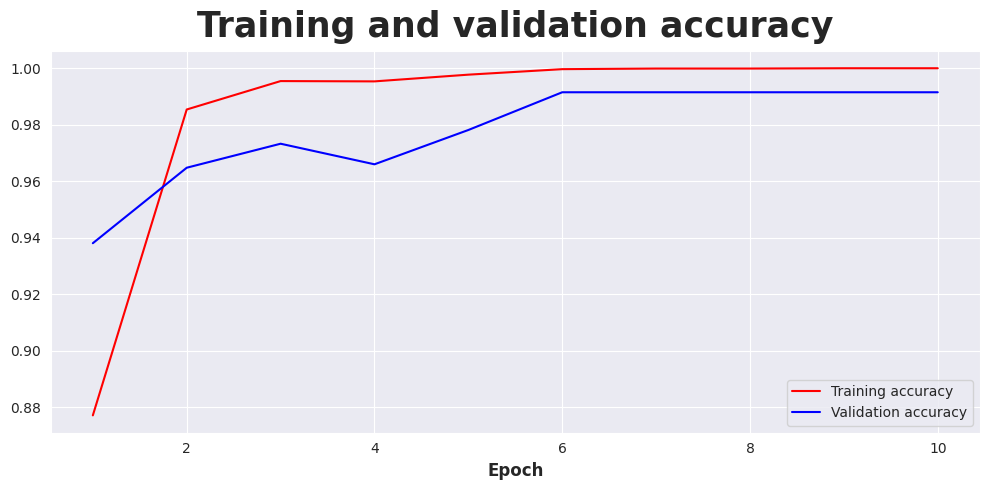

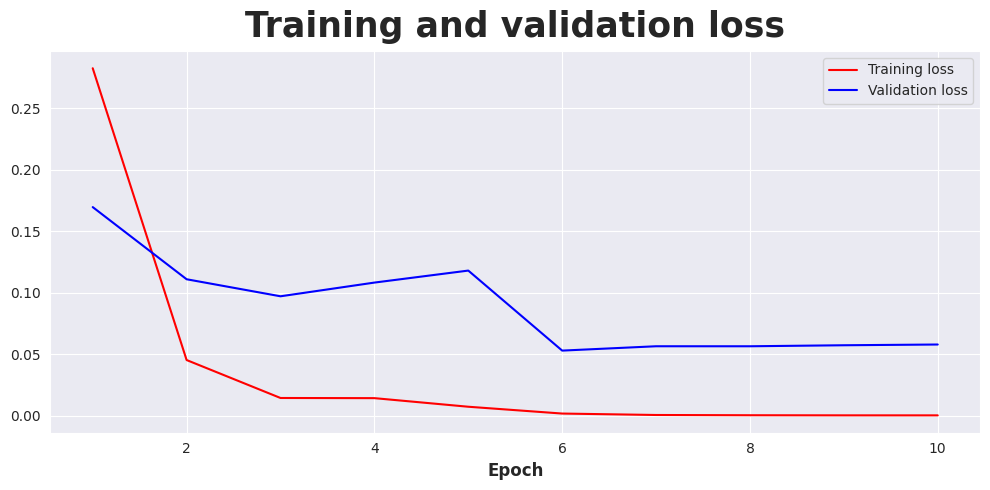

In [97]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy',)
plt.legend()
ax.set_xlabel("Epoch")
ax.tick_params()
plt.show()
#loss
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', )
plt.legend()
ax.set_xlabel("Epoch", )
ax.tick_params()
plt.show()

In [101]:
score = model.evaluate(scaled_val_data,  verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.05291236937046051
Val accuracy: 0.9914945363998413


In [112]:
score = model.evaluate(scaled_test_data, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.004274595528841019
Test accuracy: 1.0
